## Matrix Games
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\renewcommand{\a}{\alpha}             $ 
$\renewcommand{\b}{\beta}              $ 
$\renewcommand{\c}{\gamma}             $ 
$\renewcommand{\d}{\delta}             $ 
$\newcommand{\D}{\Delta}               $ 
$\newcommand{\la}{\lambda}             $ 
$\renewcommand{\t}{\tau}               $ 
$\newcommand{\s}{\sigma}               $ 
$\newcommand{\e}{\varepsilon}          $ 
$\renewcommand{\th}{\theta}            $ 
$\newcommand{\x}{\bar x}               $ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\E}{\mathcal E}           $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\newcommand{\nf}[1]{\nabla f(#1)}     $
$\newcommand{\hx}{\hat x}               $
$\newcommand{\hy}{\hat y}               $
$\DeclareMathOperator{\prox}{prox}      $
$\DeclareMathOperator{\argmin}{argmin}  $
$\DeclareMathOperator{\dom}{dom}        $
$\DeclareMathOperator{\id}{Id}          $
$\DeclareMathOperator{\conv}{conv}      $

We are interested in the following min-max matrix game
\begin{equation}
    \min_{x \in \D_n}\max_{y\in \D_m} \lr{Ax, y},
\end{equation}
where $x\in \R^n$, $y\in \R^m$, $A\in \R^{m\times n}$, and $\Delta_m$,
$\D_n$ denote the standard unit simplices in $\R^m$ and $\R^n$
respectively.

The variational inequality formulation for this problem is:
$$\lr{F(z^*),z-z^*} + G(z) - G(z^*) \geq 0 \quad \forall z \in Z,$$
where 
$$Z = \R^n\times \R^m,\quad z=\binom{x}{y},\quad F = \begin{bmatrix} 0 & A^*\\ -A & 0\end{bmatrix}, \quad G(z) = \d_{\D_n}(x) + \d_{\D_m}(y)$$


In [2]:
import matplotlib.pyplot as plt
import scipy.sparse as spr
import scipy.sparse.linalg as la

from opt_operators import *
from algorithms import *
from pd_algorithms import *
from misc_for_output import *

%reload_ext autoreload
%autoreload 2

Choose any generator for random generation of data. In the paper we set gen = 100

In [4]:
gen = 100

Define matrix $A\in \R^{m\times n}$ (choose one of four possible examples below or generate a new instance):

In [ ]:
m = 100
n = 100
np.random.seed(gen)
A = np.random.uniform(-1, 1, [m,n])

In [ ]:
m = 100
n = 100
np.random.seed(gen)
A = np.random.normal(0, 1, [m, n])

In [5]:
m = 500
n = 100
np.random.seed(gen)
A = np.random.normal(0, 10, [m, n])

In [ ]:
m = 1000
n = 2000
np.random.seed(gen)
A = spr.rand(m,n,0.1, 'csr')

Define the initial points $x^0$ and $y^0$

In [6]:
x0 = np.ones(n)/n
y0 = np.ones(m)/m
z0 = np.hstack((x0, y0))

Define all proximal operators, primal-dual gap, etc.

In [7]:
# define general proximal operator. Note that it is independent of 
# the dimension, so we will use it for both primal and dual variables
def prox_g(x, rho):
    return proj_simplex(x)

# define primal-dual gap
def J_gap(x,y):
    return max(A.dot(x)) - min(A.T.dot(y))


### For variational inequalities formulation (Tseng FBF method and PEGM)

def F(z):
    u1 = A.T.dot(z[n:])
    u2 = -A.dot(z[:n])
    return np.hstack((u1, u2))

def prox_G(z, rho):
    u1 = proj_simplex(z[:n])
    u2 = proj_simplex(z[n:])
    return np.hstack((u1, u2))

def J_vip(z):
    return J_gap(z[:n], z[n:])

Compute the matrix norm of operator $A$.

In [8]:
L = np.sqrt(np.max(LA.eigh(A.dot(A.T))[0])) # this is for dense matrix
#L = np.sqrt(np.max(la.eigsh(A.dot(A.T))[0])) # this is for sparse matrix

Define stepsizes for primal-dual method. For PDAL we use a simple guess $\t_0 =\frac{\sqrt{\min\{m,n\}}}{||A||_F}$, which is easy to compute

In [9]:
tau = 1./L
sigma = 1./L

tau0 = np.sqrt(min(m,n))/LA.norm(A) # for dense matrix
#tau0 = np.sqrt(min(m,n))/la.norm(A, 'fro') # for sparse matrix


Define number of iterations:

In [16]:
N = 100000

Run the algorithms: PDA, PDAL, Tseng FBF method, and PEGM:

In [17]:
ans1 = pd(J_gap, prox_g, prox_g, A, x0, y0, sigma, tau, numb_iter=N)
ans2 = pd_linesearch(J_gap, prox_g, prox_g, A, x0,y0, tau0, 1,   numb_iter=N)
ans3 = tseng_fbf_linesearch(J_vip, F, prox_G, z0, delta=1.4, numb_iter=N)
ans4 = alg_VI_prox_affine(J_vip, F, prox_G, z0, numb_iter=N)

----- Primal-dual method -----
Time execution: 260.641388
----- Primal-dual method with linesearch-----
Time execution: 407.54241243900003
---- FBF ----
Number of iterations: 100000
Number of gradients, n_grad: 294339
Number of prox_g: 194338
Time execution: 523.609953901
---- Alg. 2, affine operator ----
Number of iterations: 100000
Number of gradients, n_grad: 100002
Number of prox_g: 100000
Time execution: 307.53340444800006


Quick plots of the primal-dual gap vs. number of iterations:

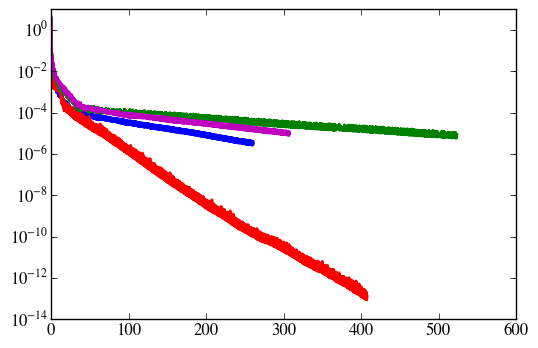

In [18]:
plt.plot(ans1[0],ans1[1], 'b',)
plt.plot(ans2[0],ans2[1], 'r',)
plt.plot(ans3[0],ans3[1], 'g',)
plt.plot(ans4[0],ans4[1], 'm')
plt.yscale('log')
plt.show()

In [19]:
answers = [ans1, ans2, ans3, ans4]
alg = ["PDA", "PDAL", "FBF", "PEGM"]

time_stamp = 200

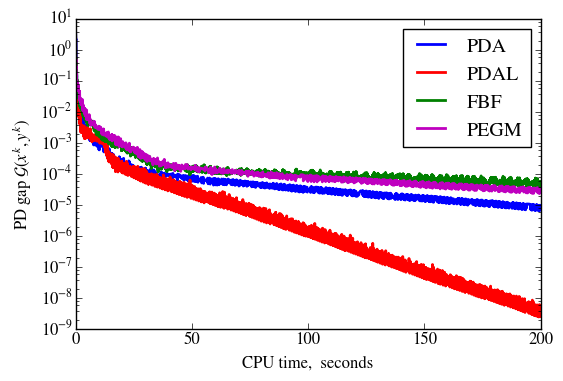

In [20]:
a1,a2 = cut_time(ans1[0],ans1[1], t=time_stamp)
b1,b2 = cut_time(ans2[0],ans2[1], t=time_stamp)
c1,c2 = cut_time(ans3[0],ans3[1], t=time_stamp)
d1,d2 = cut_time(ans4[0],ans4[1], t=time_stamp)


plt.plot(a1, a2, 'b', label = alg[0])
plt.plot(b1, b2, 'r', label = alg[1])
plt.plot(c1, c2, 'g', label = alg[2])
plt.plot(d1, d2, 'm', label = alg[3])
plt.yscale('log')
#plt.xscale('log')

plt.xlabel(u'CPU time,  seconds')
plt.ylabel(u'PD gap $\mathcal{G}(x^k,y^k)$')


plt.legend()
plt.savefig('figures/minmax-?.pdf', bbox_inches='tight')
plt.show()
plt.clf()